<a href="https://colab.research.google.com/github/akashsmu/Aero2Astro/blob/main/Multiple_orthomosaic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imutils
cv2.ocl.setUseOpenCL(False)

In [2]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 25.0MB 123kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


     |████████████████████████████████| 30.6MB 99kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


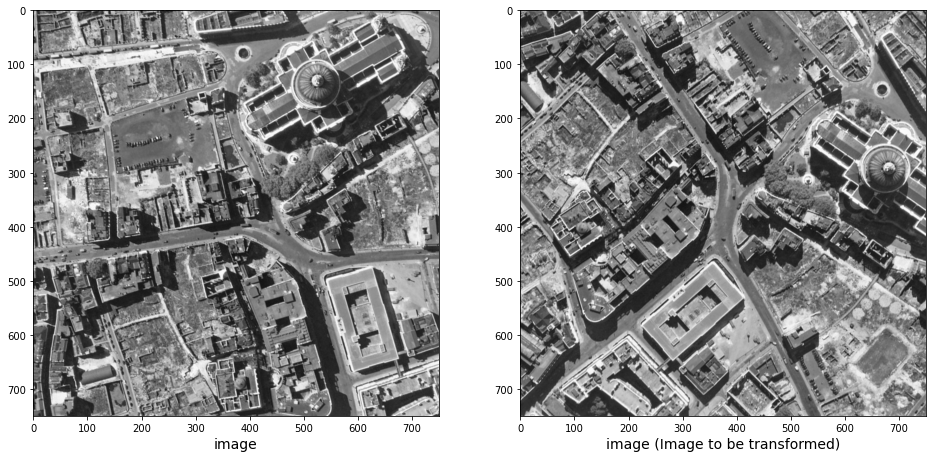

In [2]:
trainImg=imageio.imread('/content/test1.jpg')
trainImg_gray=cv2.cvtColor(trainImg,cv2.COLOR_RGB2GRAY)
Img=imageio.imread('/content/test0.jpg')
Img_gray=cv2.cvtColor(Img,cv2.COLOR_RGB2GRAY)
fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,constrained_layout=False,figsize=(16,9))
ax1.imshow(Img,cmap="gray")
ax1.set_xlabel("image",fontsize=14)
ax2.imshow(trainImg,cmap="gray")
ax2.set_xlabel("image (Image to be transformed)",fontsize=14)
plt.show()

In [3]:
def detectAndDescribe(image,method=None):
  """    Compute key points and feature descriptors using an specific method    """
  assert method is not None,"You need to define a feature detection method. Values are: 'sift', 'surf'"
  # detect and extract features from the image
  if method=='sift':
    descriptor=cv2.xfeatures2d.SIFT_create()
  elif method=='surf':
      descriptor=cv2.xfeatures2d.SURF_create()
  elif method=='brisk':
      descriptor=cv2.BRISK_create()
  elif method=='orb':
      descriptor=cv2.ORB_create()
  (kps,features)= descriptor.detectAndCompute(image,None)

  return (kps,features)
    

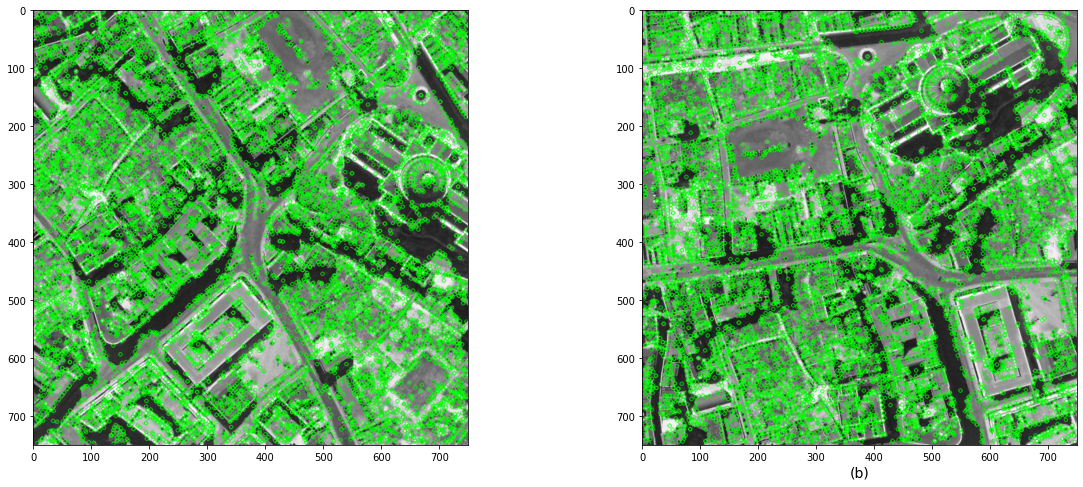

In [4]:
kpsA,featuresA=detectAndDescribe(trainImg_gray,method='sift')
kpsB,featuresB=detectAndDescribe(Img_gray,method='sift')

# display the keypoints and features detected on both images
fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(20,8),constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(trainImg_gray,kpsA,None,color=(0,255,0)))
ax1.set_xlabel("",fontsize=14)
ax2.imshow(cv2.drawKeypoints(Img_gray,kpsB,None,color=(0,255,0)))
ax2.set_xlabel("(b)",fontsize=14)
plt.show()

In [5]:
def createMatcher(method,crossCheck):
  if method=='sift'or method=='surf':
    bf=cv2.BFMatcher(cv2.NORM_L2,crossCheck=crossCheck)
  elif method=='orb'or method=='brisk':
    bf=cv2.BFMatcher(cv2.NORM_HAMMING,crossCheck=crossCheck)
  return bf

def matchKeyPointsBF(featuresA,featuresB,method):
  bf=createMatcher(method,crossCheck=True) 
  # Match descriptors.
  best_matches=bf.match(featuresA,featuresB)
  # Sort the features in order of distance.
  # The points with small distance (more similarity) are ordered first in the vector
  rawMatches=sorted(best_matches,key=lambda x:x.distance)
  print("Raw matches:",len(rawMatches))
  return rawMatches

def matchKeyPointsKNN(featuresA,featuresB,ratio,method):
  bf=createMatcher(method,crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
  rawMatches=bf.knnMatch(featuresA,featuresB,2)
  print("Raw matches:",len(rawMatches))
  matches=[]
    # loop over the raw matches
  for m,n in rawMatches:
      # ensure the distance is within a certain ratio of each# other (i.e. Lowe's ratio test)
    if m.distance<n.distance*ratio:
      matches.append(m)
  return matches

Raw matches: 7733


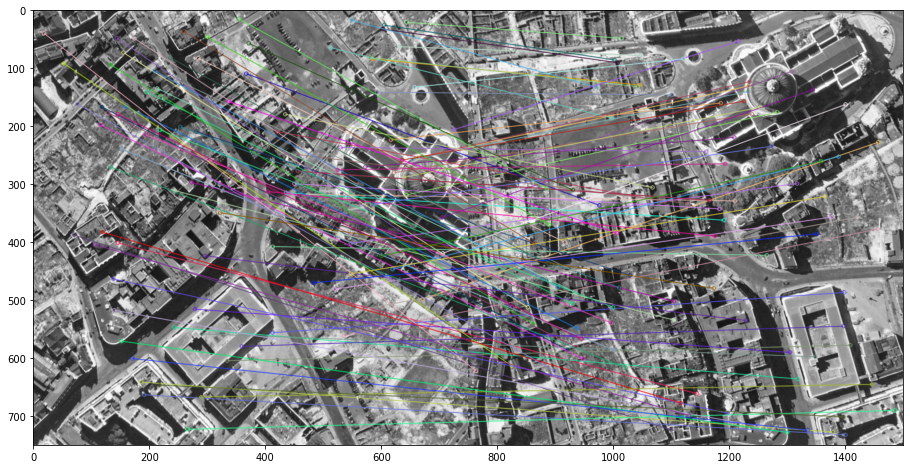

In [6]:
fig=plt.figure(figsize=(20,8))
feature_matching='bf'
if feature_matching=='bf':
  matches=matchKeyPointsBF(featuresA,featuresB,method='sift')
  img3=cv2.drawMatches(trainImg,kpsA,Img,kpsB,matches[:100],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_matching=='knn':
  matches=matchKeyPointsKNN(featuresA,featuresB,ratio=0.75,method='sift')
  img3=cv2.drawMatches(trainImg,kpsA,Img,kpsB,np.random.choice(matches,100),None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3)
plt.show()

In [7]:
def getHomography(kpsA,kpsB,featuresA,featuresB,matches,reprojThresh):
  # convert the keypoints to numpy arrays
  kpsA=np.float32([kp.pt for kp in kpsA])
  kpsB=np.float32([kp.pt for kp in kpsB])
  if len(matches)>4:
    # construct the two sets of points
    ptsA=np.float32([kpsA[m.queryIdx] for m in matches])
    ptsB=np.float32([kpsB[m.trainIdx] for m in matches])
    (H,status)=cv2.findHomography(ptsA,ptsB,cv2.RANSAC,reprojThresh)
    return (matches,H,status)
  else:
    return None


[[ 4.28032396e-01  9.02748228e-01 -2.99994388e+01]
 [-9.03890498e-01  4.27881126e-01  6.21397412e+02]
 [ 4.20836652e-08  5.48159597e-08  1.00000000e+00]]


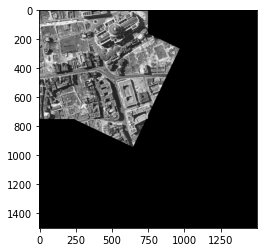

In [8]:
H=getHomography(kpsA,kpsB,featuresA,featuresB,matches,reprojThresh=4)
if H is None:
  print('Error')
(matches,H,status)=H
print(H)
width=trainImg.shape[1]+Img.shape[1]
height=trainImg.shape[0]+Img.shape[0]

result=cv2.warpPerspective(trainImg,H,(width,height))
result[0:Img.shape[0],0:Img.shape[1]]=Img


plt.imshow(result)
plt.show()

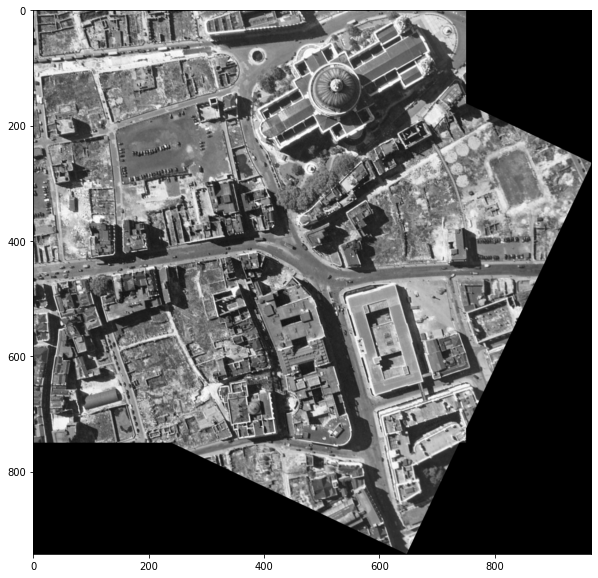

In [9]:
gray=cv2.cvtColor(result,cv2.COLOR_BGR2GRAY)
thresh=cv2.threshold(gray,0,255,cv2.THRESH_BINARY)[1]
# Finds contours from the binary image
cnts=cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts=imutils.grab_contours(cnts)
# get the maximum contour area
c=max(cnts,key=cv2.contourArea)
# get a box from the contour area
(x,y,w,h)=cv2.boundingRect(c)
# crop the image to the box coordinates
result=result[y:y+h,x:x+w]
# show the cropped image
plt.figure(figsize=(20,10))
plt.imshow(result)

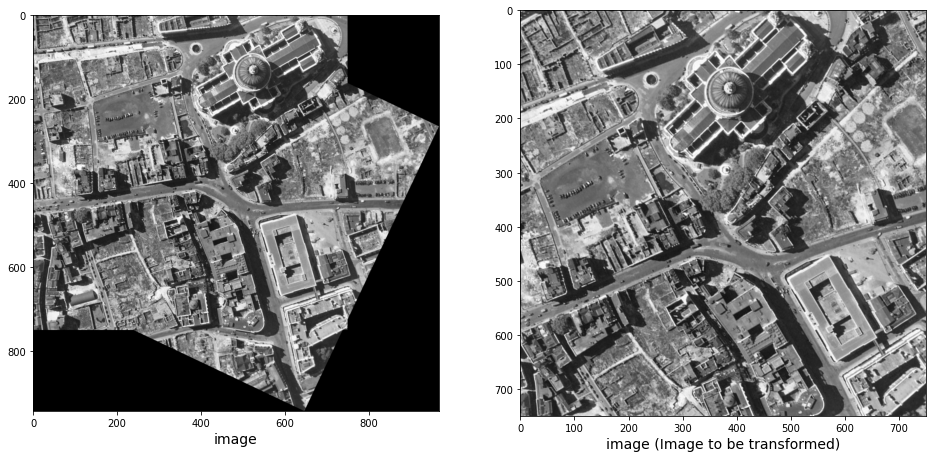

In [20]:
trainingImg=imageio.imread('/content/test2.jpg')
trainingImg_gray=cv2.cvtColor(trainingImg,cv2.COLOR_RGB2GRAY)

fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,constrained_layout=False,figsize=(16,9))
ax1.imshow(result,cmap="gray")
ax1.set_xlabel("image",fontsize=14)

ax2.imshow(trainingImg,cmap="gray")
ax2.set_xlabel("image (Image to be transformed)",fontsize=14)

plt.show()

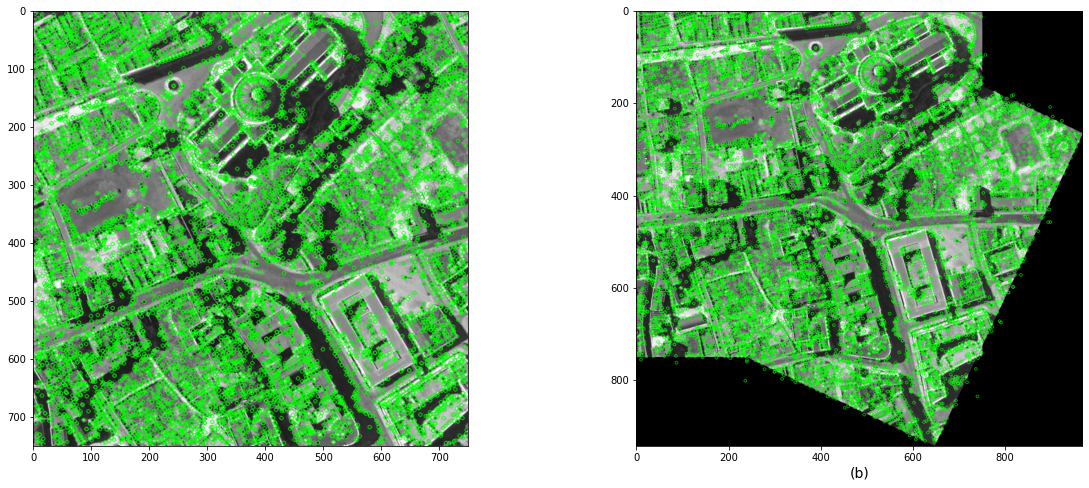

In [22]:
kpsA,featuresAA=detectAndDescribe(trainingImg_gray,method='sift')
kpsB,featuresBB=detectAndDescribe(result,method='sift')

# display the keypoints and features detected on both images
fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(20,8),constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(trainingImg_gray,kpsA,None,color=(0,255,0)))
ax1.set_xlabel("",fontsize=14)
ax2.imshow(cv2.drawKeypoints(result,kpsB,None,color=(0,255,0)))
ax2.set_xlabel("(b)",fontsize=14)
plt.show()

Raw matches: 8691


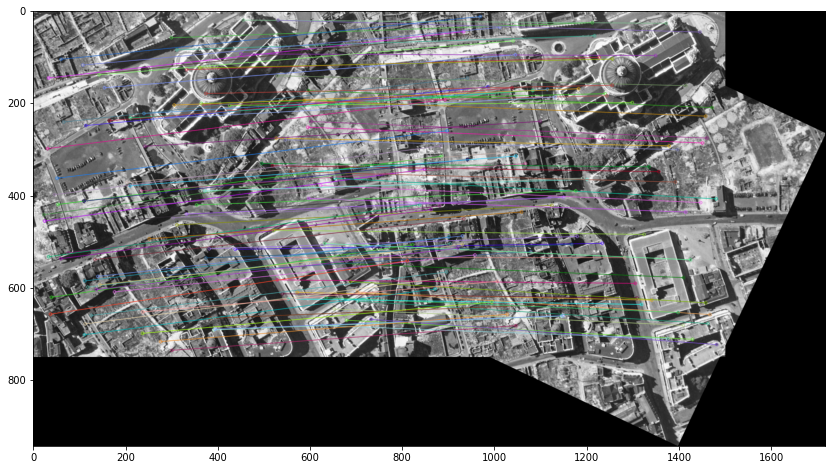

In [23]:
fig=plt.figure(figsize=(20,8))
feature_matching='bf'
if feature_matching=='bf':
  matches=matchKeyPointsBF(featuresAA,featuresBB,method='sift')
  img3=cv2.drawMatches(trainingImg,kpsA,result,kpsB,matches[:100],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_matching=='knn':
  matches=matchKeyPointsKNN(featuresAA,featuresBB,ratio=0.75,method='sift')
  img3=cv2.drawMatches(trainingImg,kpsA,result,kpsB,np.random.choice(matches,100),None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3)
plt.show()

[[ 9.68598212e-01 -2.45605284e-01  1.85564458e+02]
 [ 2.45912908e-01  9.68494333e-01 -1.04238490e+02]
 [ 1.67805648e-07  3.07338671e-08  1.00000000e+00]]


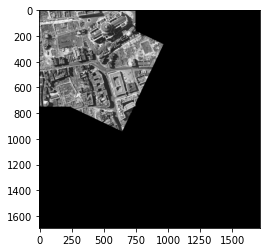

In [24]:
H=getHomography(kpsA,kpsB,featuresAA,featuresBB,matches,reprojThresh=4)
if H is None:
  print('Error')
(matches,H,status)=H
print(H)
width=trainingImg.shape[1]+result.shape[1]
height=trainingImg.shape[0]+result.shape[0]

result1=cv2.warpPerspective(trainingImg,H,(width,height))
result1[0:result.shape[0],0:result.shape[1]]=result


plt.imshow(result1)
plt.show()

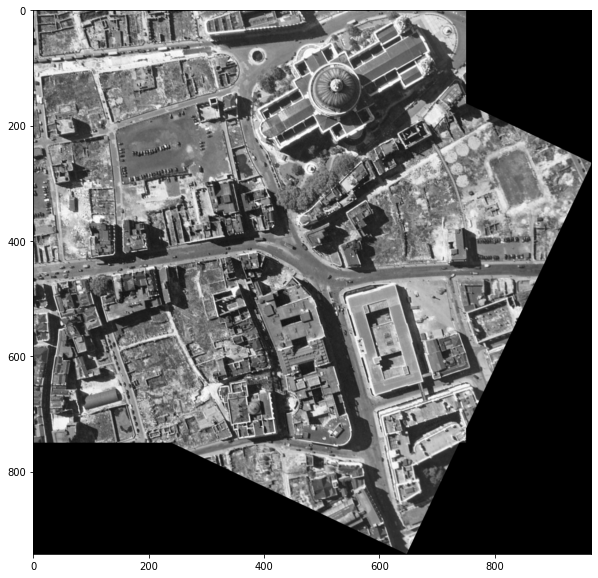

In [25]:
gray=cv2.cvtColor(result1,cv2.COLOR_BGR2GRAY)
thresh=cv2.threshold(gray,0,255,cv2.THRESH_BINARY)[1]
# Finds contours from the binary image
cnts=cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts=imutils.grab_contours(cnts)
# get the maximum contour area
c=max(cnts,key=cv2.contourArea)
# get a box from the contour area
(x,y,w,h)=cv2.boundingRect(c)
# crop the image to the box coordinates
result2=result1[y:y+h,x:x+w]
# show the cropped image
plt.figure(figsize=(20,10))
plt.imshow(result2)